>import packages and set up SparkSession

In [152]:
# import required packages

import multiprocessing
import pyspark
import os
import datetime
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import numpy as np
import setuptools #required for df.toPandas() in Python 3.12
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# define and begin SparkSession and SparkContext

cfg = (
    pyspark.SparkConf()
        # Setting the master to run locally and with the maximum amount of cpu coresfor multiprocessing.
        .setMaster(f"local[{multiprocessing.cpu_count()}]")            
        # Setting application name
        .setAppName("TestApp")
        # Setting config value via string
        .set("spark.eventLog.enabled", False)
        # Setting memory if this setting was not set previously
        .setIfMissing("spark.executor.memory", "1g")
)

session = pyspark.sql.SparkSession.builder.config(conf=cfg).getOrCreate()
sc = session.sparkContext

>Ingest data from .csv file

In [3]:
# read data

df = session.read.option("header", True).csv("LEGO_Data/sets.csv")

In [10]:
# show data to check it has been loaded properly

df.show()

+------+--------------------+----+--------------------+-----------+---------+--------+---------------+----------------+---------------+------+-----------+-----+------+--------+--------------+-------------+
|Set_ID|                Name|Year|               Theme|Theme_Group| Subtheme|Category|      Packaging|Num_Instructions|   Availability|Pieces|Minifigures|Owned|Rating|USD_MSRP|Total_Quantity|Current_Price|
+------+--------------------+----+--------------------+-----------+---------+--------+---------------+----------------+---------------+------+-----------+-----+------+--------+--------------+-------------+
|  75-1|       PreSchool Set|1975|           PreSchool| Pre-school|     NULL|  Normal|{Not specified}|               0|{Not specified}|  16.0|       NULL| 10.0|   0.0|    NULL|          NULL|         NULL|
|  77-1|       PreSchool Set|1975|           PreSchool| Pre-school|     NULL|  Normal|{Not specified}|               0|{Not specified}|  20.0|       NULL| 11.0|   0.0|    NULL|

>Get rolling average of piece count by year and plot on a graph

In [12]:
# get rolling average of piece count for lego sets, ignoring Duplo sets and books
# note that this code is built to calculate rolling averages but currently is just calculating the average
# for each year

timeRange = 1 #set time range for rolling average in years

W = Window().orderBy(df.Year.cast('int')).rangeBetween(-timeRange+1, 0)
dfRA = df.filter(df.Theme != "Books").filter(df.Theme != "Duplo").withColumn('roll', F.avg("Pieces").over(W)) \
    .select('Year', F.round('roll',2).alias('Rolling_AVG')) \
    .distinct()

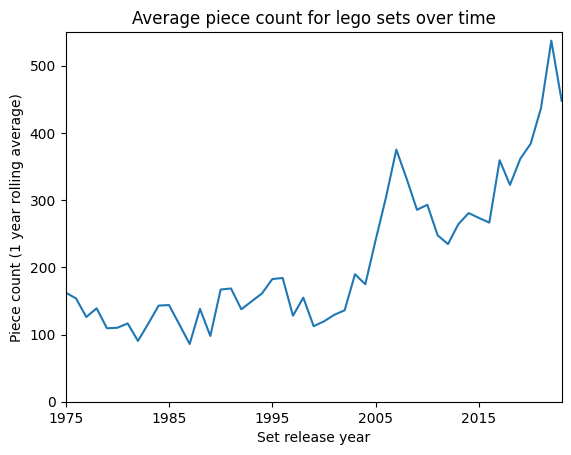

In [15]:
# plot average piece count as a function of time

xMin = int(dfRA.agg({"Year": "min"}).collect()[0][0])
xMax = int(df.agg({"Year": "max"}).collect()[0][0])
dfRApd = dfRA.toPandas()
ax = dfRApd.plot(kind='line',x='Year',y='Rolling_AVG', legend=None, \
                    xlabel='Set release year', \
                    ylabel=f'Piece count ({timeRange} year rolling average)', \
                    title='Average piece count for lego sets over time', \
                    xlim=(0,xMax-xMin), \
                    ylim=(0,550))

>Fit curve to average piece count data

In [76]:
# format data as Python lists

xyData = dfRApd.to_numpy()
n = len(xyData)
xData, yData = [0]*n, [0]*n
for i in range(n):
    xData[i] = int(xyData[i][0])
    yData[i] = xyData[i][1]

In [129]:
# define fitting functions to use as ansatzs for curve

def exponential(x,a,b,c,d):
    return a*np.exp(b*(x-c))+d

def cubic(x,a,b,c,d,e):
    x = x-e
    return a*x**3 + b*x**2 + c*x + d

def quartic(x,a,b,c,d,e,f):
    x = x-f
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [136]:
# fit curves to determine parameters

paramsExp, pcov = curve_fit(exponential, xData, yData, (1,1,1975,1))
paramsCubic, pcov = curve_fit(cubic, xData, yData, (1,1,1,100,1975))
paramsQuartic, pcov = curve_fit(quartic, xData, yData, (1,1,1,1,100,1975))

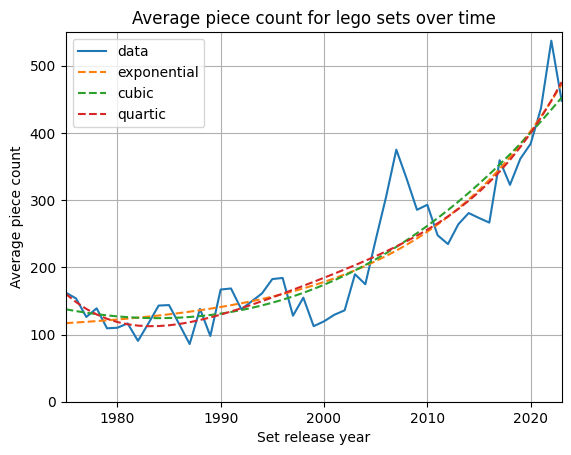

In [140]:
# plot fits on top of data to determine visually which is the best fit
# perhaps later can determine this more rigorously

# cubic seems to give the most reasonable result

plt.plot(xData, yData)
plt.plot(xData, exponential(xData,*paramsExp), '--')
plt.plot(xData, cubic(xData,*paramsCubic), '--')
plt.plot(xData, quartic(xData,*paramsQuartic), '--')
plt.legend(('data','exponential','cubic','quartic'))

plt.xlabel('Set release year')
plt.ylabel('Average piece count')
plt.xlim((xMin,xMax))
plt.ylim(0,550)
plt.grid()
plt.title('Average piece count for lego sets over time')

plt.show()

In [139]:
# print predicted values for 10 years time (2033)
# our best fit (cubic) gives an average piece count of 666.31

print(exponential(2033,*paramsExp))
print(cubic(2033,*paramsCubic))
print(quartic(2033,*paramsQuartic))

842.3344692156741
666.3141514032102
932.9492476122632


>Predicting price rises

In [167]:
dfPR = df.filter(df.Current_Price != "NULL").filter(df.USD_MSRP != "NULL") \
    .withColumn('Price_Diff', F.round(df.Current_Price.cast("float")-df.USD_MSRP.cast("float"), 2))
dfPR = dfPR.groupBy("Year").agg({'Price_Diff': 'mean'}).sort('Year')
dfPRpd = dfPR.toPandas()



In [188]:
xyData = dfPRpd.to_numpy()
n = len(xyData)
xData, yData = [0]*n, [0]*n
yTotal = 0
for i in range(n):
    yTotal += xyData[0][1]
for i in range(n):
    xData[i] = i
    yData[i] = float(xyData[i][1])

In [236]:
def hump(x,a,b,c,d):
    return a/(1+b*(x-c)**2)+d

In [237]:
paramsHump, pcov = curve_fit(hump,xData,yData,(175,0.5,10,-8))


In [238]:
paramsHump

array([ 1.55104919e+02,  9.20242962e-02,  1.14223746e+01, -2.52469007e+00])

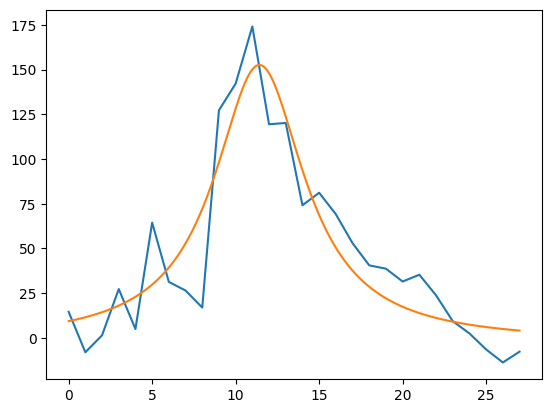

In [241]:
plt.plot(xData,yData)
yNew = []
for i in range(len(xData)):
    yNew.append(hump(xData[i],175,0.5,10,-8))
xSmooth = np.linspace(min(xData),max(xData),1000)
plt.plot(xSmooth, hump(xSmooth, *paramsHump))
